# Prover Activity Analysis

This notebook analyzes prover activity from January 18, 2026 onwards by fetching data from the Boundless Explorer API and plotting:
- `total_requests_locked` over time for the top 10 provers
- `locked_orders_fulfillment_rate` over time for the top 10 provers

In [30]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
import time

# API configuration
API_BASE_URL = "https://d2mdvlnmyov1e1.cloudfront.net"

# Set matplotlib style
plt.style.use('default')
%matplotlib inline

print(f"API Base URL: {API_BASE_URL}")

API Base URL: https://d2mdvlnmyov1e1.cloudfront.net


## Helper Functions

In [31]:
def shorten_address(address):
    """Shorten an Ethereum address for display (e.g., 0xf607...094f)."""
    if not address or len(address) < 10:
        return address
    return f"{address[:6]}...{address[-4:]}"


def test_api_connection():
    """Test if the API is accessible."""
    try:
        response = requests.get(f"{API_BASE_URL}/health", timeout=5)
        response.raise_for_status()
        return True
    except requests.exceptions.ConnectionError:
        print(f"Cannot connect to API at {API_BASE_URL}")
        return False
    except Exception as e:
        print(f"Error connecting to API: {e}")
        return False


# Test connection
if test_api_connection():
    print("API connection successful")
else:
    print("API connection failed")

API connection successful


## Fetch Active Provers

Fetch all provers that have been active in the past 7 days (API period filter).

In [32]:
def fetch_active_provers(period='7d', limit=100):
    """
    Fetch all active provers for the specified time period.
    
    Args:
        period: Time period for leaderboard ('7d', '30d', etc.)
        limit: Maximum results per page (max 100)
    
    Returns:
        List of prover data dictionaries
    """
    all_provers = []
    cursor = None
    
    while True:
        params = {
            'period': period,
            'limit': limit
        }
        
        if cursor:
            params['cursor'] = cursor
        
        try:
            response = requests.get(
                f"{API_BASE_URL}/v1/market/provers",
                params=params,
                timeout=30
            )
            response.raise_for_status()
            data = response.json()
            
            provers = data.get('data', [])
            all_provers.extend(provers)
            
            # Check for more pages
            if not data.get('has_more', False):
                break
            
            cursor = data.get('next_cursor')
            if not cursor:
                break
                
        except Exception as e:
            print(f"Error fetching provers: {e}")
            break
    
    print(f"Fetched {len(all_provers)} active provers for period '{period}'")
    return all_provers


# Fetch provers
provers = fetch_active_provers(period='7d')

# Display summary
if provers:
    print("\nTop 10 provers by fees earned:")
    for i, p in enumerate(provers[:10]):
        addr = p.get('prover_address', 'Unknown')
        fees = p.get('fees_earned_formatted', '0 ETH')
        orders = p.get('orders_locked', 0)
        print(f"  {i+1}. {shorten_address(addr)}: {fees} ({orders} orders locked)")

Fetched 51 active provers for period '7d'

Top 10 provers by fees earned:
  1. 0xf607...094f: 0.745761051992919796 ETH (17099 orders locked)
  2. 0x9c65...a38d: 0.455412234634246521 ETH (8573 orders locked)
  3. 0xe85d...7d93: 0.396123268502687322 ETH (886 orders locked)
  4. 0xfd6c...3703: 0.310485864124321380 ETH (1323 orders locked)
  5. 0x20d7...ac38: 0.157010274956632931 ETH (2002 orders locked)
  6. 0xff95...5b9d: 0.145196666666666621 ETH (142 orders locked)
  7. 0x5778...c982: 0.130555033333333270 ETH (200 orders locked)
  8. 0x15aa...185a: 0.074043333333333300 ETH (91 orders locked)
  9. 0x07f6...e0d3: 0.065184999999999967 ETH (101 orders locked)
  10. 0xa6c2...a024: 0.054217253312371164 ETH (1424 orders locked)


## Fetch Prover Aggregates

For each prover, fetch hourly aggregates for the past 4 days.

In [33]:
def fetch_prover_aggregates(address, aggregation='hourly', start_date=None, limit=1000):
    """
    Fetch aggregated data for a specific prover.
    
    Args:
        address: Prover Ethereum address
        aggregation: 'hourly', 'daily', 'weekly', or 'monthly'
        start_date: Start date as datetime object (default: Jan 20, 2026)
        limit: Maximum results per page
    
    Returns:
        pandas DataFrame with aggregate data
    """
    all_data = []
    cursor = None
    
    # Use start_date or default to January 20, 2026
    if start_date is None:
        start_date = datetime(2026, 1, 18)
    
    # Calculate timestamp for 'after' filter
    after_timestamp = int(start_date.timestamp())
    
    while True:
        params = {
            'aggregation': aggregation,
            'limit': limit,
            'sort': 'asc',
            'after': after_timestamp
        }
        
        if cursor:
            params['cursor'] = cursor
        
        try:
            response = requests.get(
                f"{API_BASE_URL}/v1/market/provers/{address}/aggregates",
                params=params,
                timeout=30
            )
            response.raise_for_status()
            data = response.json()
            
            records = data.get('data', [])
            all_data.extend(records)
            
            # Check for more pages
            if not data.get('has_more', False):
                break
            
            cursor = data.get('next_cursor')
            if not cursor:
                break
                
        except Exception as e:
            print(f"Error fetching aggregates for {shorten_address(address)}: {e}")
            break
    
    if not all_data:
        return pd.DataFrame()
    
    # Convert to DataFrame
    df = pd.DataFrame(all_data)
    
    # Parse timestamps
    if 'timestamp_iso' in df.columns:
        df['datetime'] = pd.to_datetime(df['timestamp_iso'])
    elif 'timestamp' in df.columns:
        df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')
    
    # Normalize timezone
    if df['datetime'].dt.tz is not None:
        df['datetime'] = df['datetime'].dt.tz_convert('UTC').dt.tz_localize(None)
    
    # Sort by datetime
    df = df.sort_values('datetime').reset_index(drop=True)
    
    return df

## Collect Data for All Provers

In [34]:
def collect_all_prover_aggregates(provers, aggregation='hourly', start_date=None):
    """
    Collect hourly aggregates for all provers.
    
    Args:
        provers: List of prover data from fetch_active_provers
        aggregation: Aggregation granularity
        start_date: Start date as datetime object (default: Jan 20, 2026)
    
    Returns:
        Dictionary mapping prover address to DataFrame
    """
    prover_data = {}
    total = len(provers)
    
    # Use start_date or default to January 20, 2026
    if start_date is None:
        start_date = datetime(2026, 1, 18)
    
    for i, prover in enumerate(provers):
        address = prover.get('prover_address')
        if not address:
            continue
        
        print(f"Fetching aggregates for prover {i+1}/{total}: {shorten_address(address)}...", end='')
        
        df = fetch_prover_aggregates(address, aggregation=aggregation, start_date=start_date)
        
        # Filter to only include data from start_date onwards
        if not df.empty and 'datetime' in df.columns:
            # Ensure start_date is timezone-naive for comparison
            start_date_naive = start_date.replace(tzinfo=None) if start_date.tzinfo else start_date
            df = df[df['datetime'] >= start_date_naive].copy()
            
            # Debug: print date range if data exists
            if not df.empty:
                min_date = df['datetime'].min()
                max_date = df['datetime'].max()
                print(f" {len(df)} records (from {min_date.strftime('%Y-%m-%d %H:%M')} to {max_date.strftime('%Y-%m-%d %H:%M')})")
        
        if not df.empty:
            prover_data[address] = df
        else:
            print(" no data")
        
        # Small delay to be nice to the API
        time.sleep(0.2)
    
    print(f"\nCollected data for {len(prover_data)} provers")
    return prover_data


# Collect all prover aggregates from January 18, 2026 onwards
# Note: Set timezone to UTC and ensure it's timezone-naive for consistency
start_date = datetime(2026, 1, 18, 0, 0, 0)
print(f"Collecting hourly data from {start_date.strftime('%Y-%m-%d %H:%M:%S')} onwards...")
prover_aggregates_hourly = collect_all_prover_aggregates(provers, aggregation='hourly', start_date=start_date)

print(f"\nCollecting daily data from {start_date.strftime('%Y-%m-%d %H:%M:%S')} onwards...")
prover_aggregates_daily = collect_all_prover_aggregates(provers, aggregation='daily', start_date=start_date)

# Keep hourly as prover_aggregates for backward compatibility
prover_aggregates = prover_aggregates_hourly

# Print summary of date ranges in collected data
if prover_aggregates:
    all_dates = []
    for address, df in prover_aggregates.items():
        if 'datetime' in df.columns and not df.empty:
            all_dates.extend(df['datetime'].tolist())
    if all_dates:
        min_date = min(all_dates)
        max_date = max(all_dates)
        print(f"\nData range: {min_date.strftime('%Y-%m-%d %H:%M')} to {max_date.strftime('%Y-%m-%d %H:%M')}")
        print(f"Earliest data: {min_date.strftime('%Y-%m-%d %H:%M:%S')}")
        print(f"Latest data: {max_date.strftime('%Y-%m-%d %H:%M:%S')}")

Fetching aggregates for prover 1/51: 0xf607...094f... 205 records (from 2026-01-18 07:00 to 2026-01-26 19:00)
Fetching aggregates for prover 2/51: 0x9c65...a38d... 205 records (from 2026-01-18 07:00 to 2026-01-26 19:00)
Fetching aggregates for prover 3/51: 0xe85d...7d93... 205 records (from 2026-01-18 07:00 to 2026-01-26 19:00)
Fetching aggregates for prover 4/51: 0xfd6c...3703... 205 records (from 2026-01-18 07:00 to 2026-01-26 19:00)
Fetching aggregates for prover 5/51: 0x20d7...ac38... 205 records (from 2026-01-18 07:00 to 2026-01-26 19:00)
Fetching aggregates for prover 6/51: 0xff95...5b9d... 205 records (from 2026-01-18 07:00 to 2026-01-26 19:00)
Fetching aggregates for prover 7/51: 0x5778...c982... 189 records (from 2026-01-18 07:00 to 2026-01-26 19:00)
Fetching aggregates for prover 8/51: 0x15aa...185a... 205 records (from 2026-01-18 07:00 to 2026-01-26 19:00)
Fetching aggregates for prover 9/51: 0x07f6...e0d3... 205 records (from 2026-01-18 07:00 to 2026-01-26 19:00)
Fetching a

## Plot Total Requests Locked Over Time

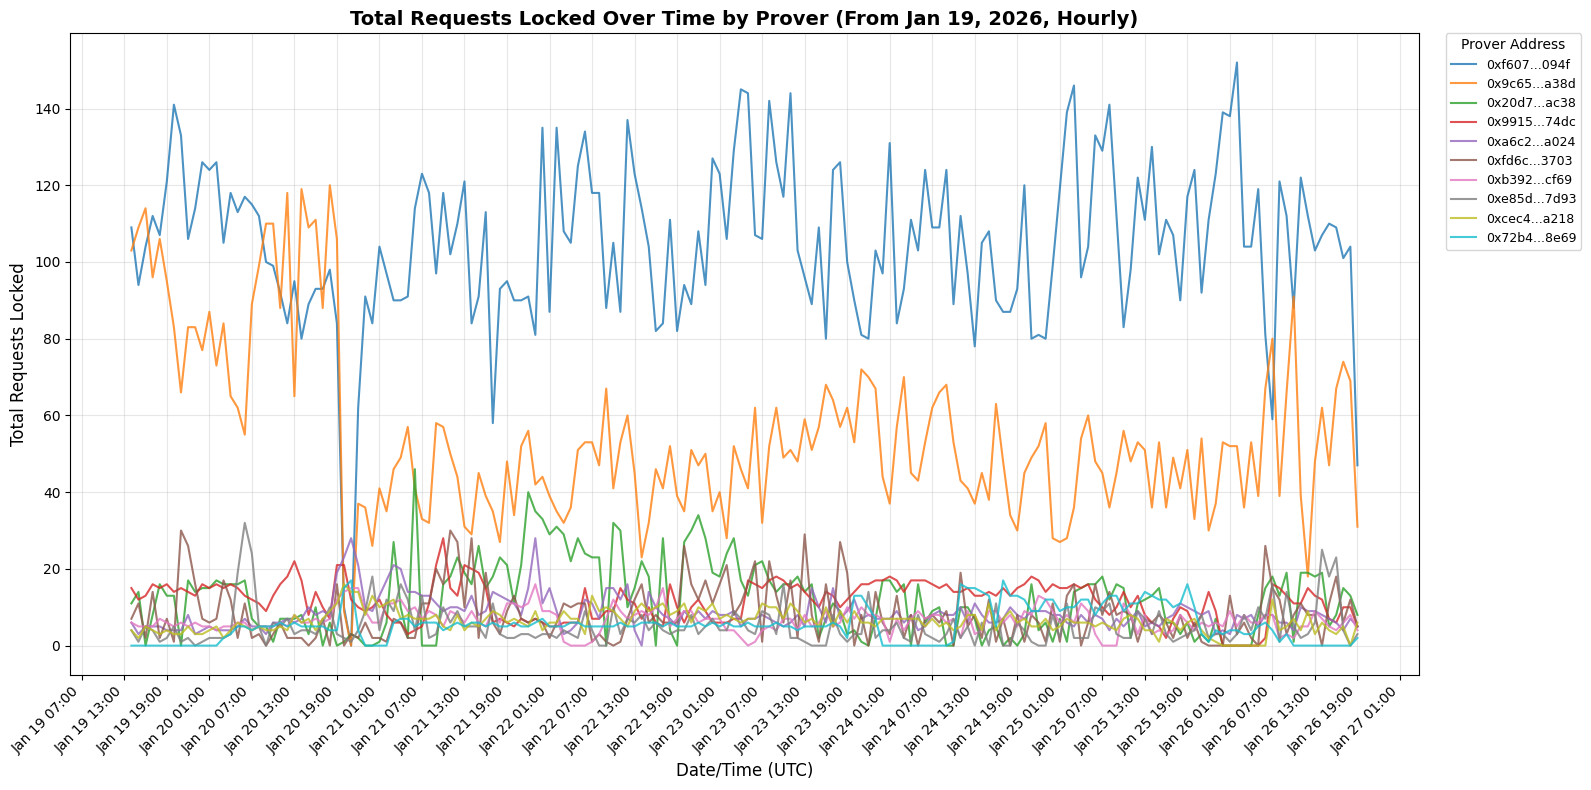


Provers plotted: 10

Total requests locked (past 7 days):
  0xf607...094f: 21,965
  0x9c65...a38d: 12,118
  0x20d7...ac38: 2,410
  0x9915...74dc: 2,397
  0xa6c2...a024: 1,680
  0xfd6c...3703: 1,609
  0xb392...cf69: 1,273
  0xe85d...7d93: 1,221
  0xcec4...a218: 1,211
  0x72b4...8e69: 1,016


In [35]:
import matplotlib.dates as mdates

def plot_requests_locked_by_prover(prover_data, top_n=10, start_date=None):
    """
    Plot total_requests_locked over time for top provers.
    
    Args:
        prover_data: Dictionary mapping prover address to DataFrame
        top_n: Number of top provers to plot (default 10)
        start_date: Start date as datetime object (for title)
    """
    if not prover_data:
        print("No data to plot")
        return
    
    # Calculate total requests per prover for sorting
    prover_totals = {}
    for address, df in prover_data.items():
        if 'total_requests_locked' in df.columns:
            prover_totals[address] = df['total_requests_locked'].sum()
        else:
            prover_totals[address] = 0
    
    # Sort provers by total requests (descending)
    sorted_provers = sorted(prover_totals.keys(), key=lambda x: prover_totals[x], reverse=True)
    
    # Limit to top N
    if top_n:
        sorted_provers = sorted_provers[:top_n]
    
    # Create figure
    fig, ax = plt.subplots(figsize=(16, 8))
    
    # Color palette
    colors = plt.cm.tab10(np.linspace(0, 1, len(sorted_provers)))
    
    # Plot each prover
    for i, address in enumerate(sorted_provers):
        df = prover_data[address].copy()
        if 'total_requests_locked' not in df.columns:
            continue
        
        # Filter data to start_date if provided
        if start_date and 'datetime' in df.columns:
            df = df[df['datetime'] >= start_date].copy()
        
        if df.empty:
            continue
        
        label = shorten_address(address)
        ax.plot(
            df['datetime'],
            df['total_requests_locked'],
            label=label,
            linewidth=1.5,
            alpha=0.8,
            color=colors[i]
        )
    
    # Format x-axis - use daily locator if data appears to be daily, otherwise hourly
    # Check first prover's data to determine if it's daily or hourly
    sample_df = None
    for addr in sorted_provers:
        if addr in prover_data and 'datetime' in prover_data[addr].columns:
            sample_df = prover_data[addr]
            break
    
    if sample_df is not None and not sample_df.empty:
        time_diff = (sample_df['datetime'].max() - sample_df['datetime'].min()).total_seconds() / 3600
        # If time span is large relative to number of points, likely daily data
        if len(sample_df) > 0 and time_diff / len(sample_df) > 20:
            ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
        else:
            ax.xaxis.set_major_locator(mdates.HourLocator(interval=6))
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d %H:%M'))
    else:
        ax.xaxis.set_major_locator(mdates.HourLocator(interval=6))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d %H:%M'))
    
    # Formatting
    ax.set_xlabel('Date/Time (UTC)', fontsize=12)
    ax.set_ylabel('Total Requests Locked', fontsize=12)
    # Format title with date range
    if start_date:
        title = f'Total Requests Locked Over Time by Prover (From {start_date.strftime("%b %d, %Y")}, Hourly)'
    else:
        title = 'Total Requests Locked Over Time by Prover (Hourly)'
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Legend
    ax.legend(
        loc='upper left',
        bbox_to_anchor=(1.02, 1),
        borderaxespad=0,
        fontsize=9,
        title='Prover Address'
    )
    
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print(f"\nProvers plotted: {len(sorted_provers)}")
    # Format summary text
    if start_date:
        days_diff = (datetime.now() - start_date).days
        if 6 <= days_diff <= 8:
            date_str = "past 7 days"
        else:
            date_str = f"from {start_date.strftime('%b %d, %Y')}"
    else:
        date_str = "period"
    print(f"\nTotal requests locked ({date_str}):")
    for addr in sorted_provers:
        print(f"  {shorten_address(addr)}: {prover_totals[addr]:,}")


def plot_fulfillment_rate_by_prover(prover_data, top_n=10, start_date=None):
    """
    Plot locked_orders_fulfillment_rate over time for top provers.
    
    Args:
        prover_data: Dictionary mapping prover address to DataFrame
        top_n: Number of top provers to plot (default 10)
        start_date: Start date as datetime object (for title)
    """
    if not prover_data:
        print("No data to plot")
        return
    
    # Calculate total requests per prover for sorting (use same logic as requests_locked)
    prover_totals = {}
    for address, df in prover_data.items():
        if 'total_requests_locked' in df.columns:
            prover_totals[address] = df['total_requests_locked'].sum()
        else:
            prover_totals[address] = 0
    
    # Sort provers by total requests (descending)
    sorted_provers = sorted(prover_totals.keys(), key=lambda x: prover_totals[x], reverse=True)
    
    # Limit to top N
    if top_n:
        sorted_provers = sorted_provers[:top_n]
    
    # Create figure
    fig, ax = plt.subplots(figsize=(16, 8))
    
    # Color palette
    colors = plt.cm.tab10(np.linspace(0, 1, len(sorted_provers)))
    
    # Plot each prover
    for i, address in enumerate(sorted_provers):
        df = prover_data[address].copy()
        if 'locked_orders_fulfillment_rate' not in df.columns:
            continue
        
        # Filter data to start_date if provided
        if start_date and 'datetime' in df.columns:
            df = df[df['datetime'] >= start_date].copy()
        
        if df.empty:
            continue
        
        # Replace 0 values with 100 (0 means prover wasn't active, so show as 100%)
        fulfillment_rate = df['locked_orders_fulfillment_rate'].copy()
        fulfillment_rate = fulfillment_rate.replace(0, 100)
        
        label = shorten_address(address)
        ax.plot(
            df['datetime'],
            fulfillment_rate,
            label=label,
            linewidth=1.5,
            alpha=0.8,
            color=colors[i]
        )
    
    # Format x-axis - use daily locator if data appears to be daily, otherwise hourly
    # Check first prover's data to determine if it's daily or hourly
    sample_df = None
    for addr in sorted_provers:
        if addr in prover_data and 'datetime' in prover_data[addr].columns:
            sample_df = prover_data[addr]
            break
    
    if sample_df is not None and not sample_df.empty:
        time_diff = (sample_df['datetime'].max() - sample_df['datetime'].min()).total_seconds() / 3600
        # If time span is large relative to number of points, likely daily data
        if len(sample_df) > 0 and time_diff / len(sample_df) > 20:
            ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
        else:
            ax.xaxis.set_major_locator(mdates.HourLocator(interval=6))
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d %H:%M'))
    else:
        ax.xaxis.set_major_locator(mdates.HourLocator(interval=6))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d %H:%M'))
    
    # Formatting
    ax.set_xlabel('Date/Time (UTC)', fontsize=12)
    ax.set_ylabel('Fulfillment Rate', fontsize=12)
    # Format title with date range
    if start_date:
        title = f'Locked Orders Fulfillment Rate Over Time by Prover (From {start_date.strftime("%b %d, %Y")}, Hourly)'
    else:
        title = 'Locked Orders Fulfillment Rate Over Time by Prover (Hourly)'
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Legend
    ax.legend(
        loc='upper left',
        bbox_to_anchor=(1.02, 1),
        borderaxespad=0,
        fontsize=9,
        title='Prover Address'
    )
    
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print(f"\nProvers plotted: {len(sorted_provers)}")
    date_str = start_date.strftime("%b %d, %Y") if start_date else "period"
    print(f"\nAverage fulfillment rate (from {date_str}, 0s replaced with 100):")
    for addr in sorted_provers:
        df = prover_data[addr].copy()
        if 'locked_orders_fulfillment_rate' in df.columns:
            # Filter to start_date if provided
            if start_date and 'datetime' in df.columns:
                df = df[df['datetime'] >= start_date].copy()
            
            if not df.empty:
                # Replace 0 with 100 for average calculation
                fulfillment_rate = df['locked_orders_fulfillment_rate'].replace(0, 100)
                avg_rate = fulfillment_rate.mean()
                print(f"  {shorten_address(addr)}: {avg_rate:.4f}")


# Plot top 10 provers
try:
    # Use past 7 days for total requests locked plot
    start_date = datetime.now() - timedelta(days=7)
    plot_requests_locked_by_prover(prover_aggregates, top_n=10, start_date=start_date)
except NameError:
    print("Error: prover_aggregates not found. Please run the 'Collect Data for All Provers' cell first.")

## Plot Fulfillment Rate Over Time

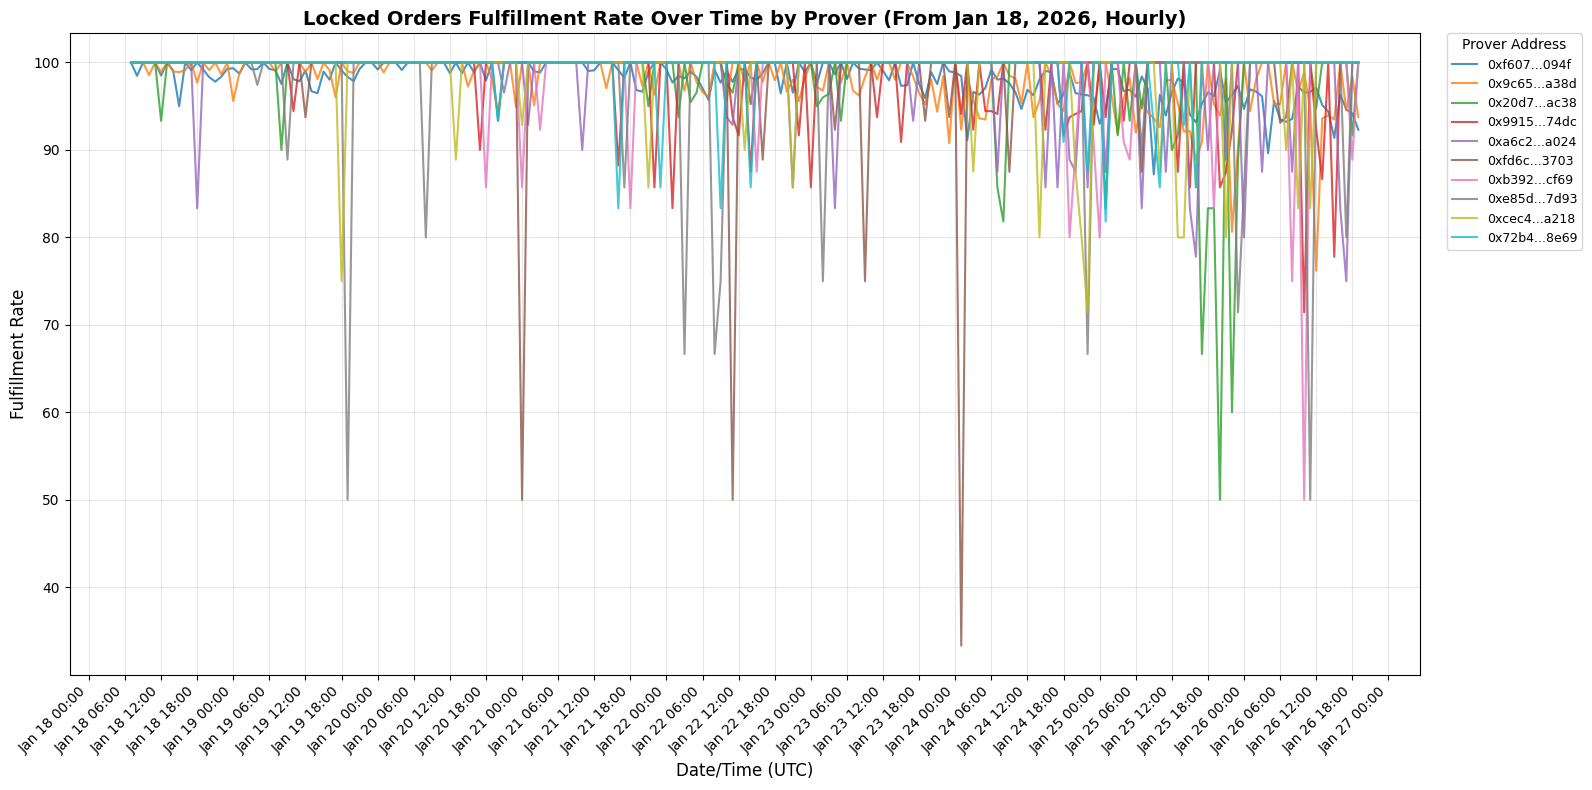


Provers plotted: 10

Average fulfillment rate (from Jan 18, 2026, 0s replaced with 100):
  0xf607...094f: 98.0030
  0x9c65...a38d: 97.8774
  0x20d7...ac38: 98.3893
  0x9915...74dc: 98.3379
  0xa6c2...a024: 98.2655
  0xfd6c...3703: 98.6705
  0xb392...cf69: 98.7927
  0xe85d...7d93: 98.1911
  0xcec4...a218: 98.5097
  0x72b4...8e69: 99.2624


In [36]:
# Plot fulfillment rate for top 10 provers
try:
    start_date = datetime(2026, 1, 18)
    plot_fulfillment_rate_by_prover(prover_aggregates, top_n=10, start_date=start_date)
except NameError:
    print("Error: prover_aggregates not found. Please run the 'Collect Data for All Provers' cell first.")

## Daily Plots

Daily aggregated data for a longer-term view.

### Daily Total Requests Locked Over Time

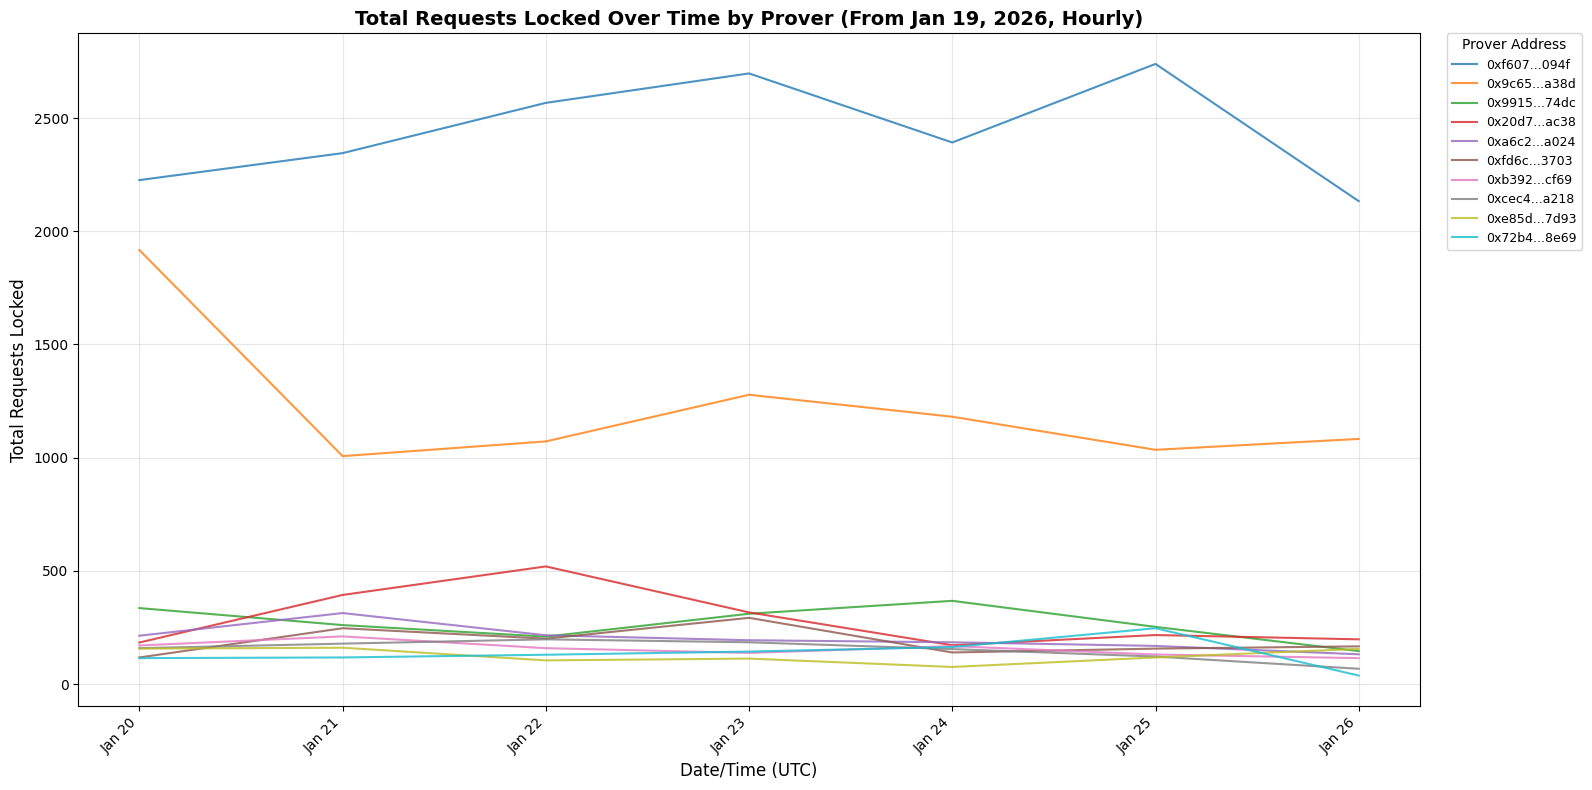


Provers plotted: 10

Total requests locked (past 7 days):
  0xf607...094f: 19,930
  0x9c65...a38d: 10,632
  0x9915...74dc: 2,221
  0x20d7...ac38: 2,206
  0xa6c2...a024: 1,569
  0xfd6c...3703: 1,517
  0xb392...cf69: 1,219
  0xcec4...a218: 1,162
  0xe85d...7d93: 1,054
  0x72b4...8e69: 958


In [37]:
try:
    # Use past 7 days for total requests locked plot (daily)
    start_date = datetime.now() - timedelta(days=7)
    if 'prover_aggregates_daily' in locals() and prover_aggregates_daily:
        plot_requests_locked_by_prover(prover_aggregates_daily, top_n=10, start_date=start_date)
    else:
        print("Error: prover_aggregates_daily not found. Please run the 'Collect Data for All Provers' cell first.")
except NameError:
    print("Error: prover_aggregates_daily not found. Please run the 'Collect Data for All Provers' cell first.")

### Daily Fulfillment Rate Over Time

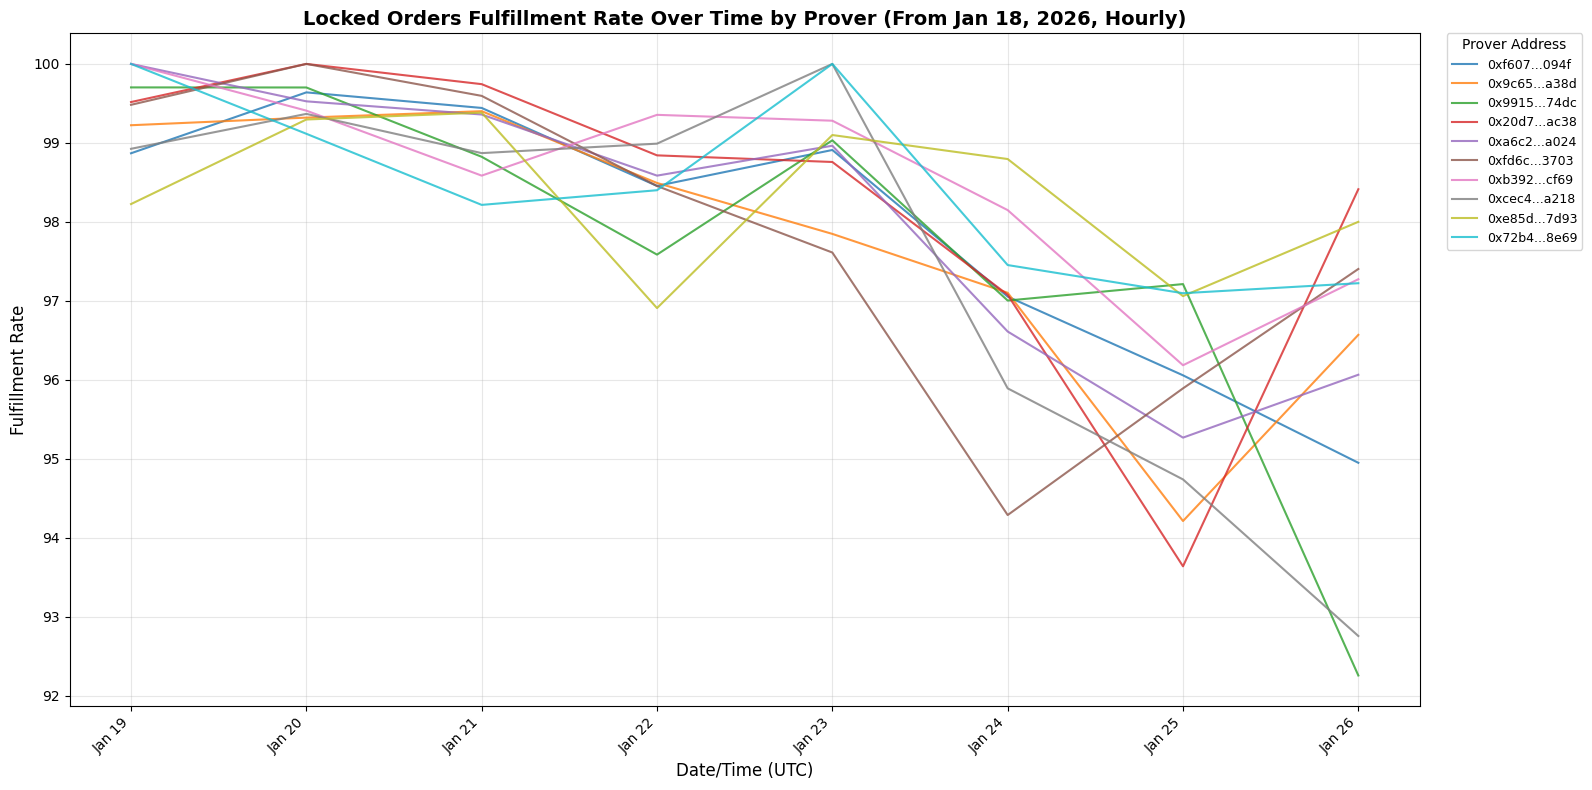


Provers plotted: 10

Average fulfillment rate (from Jan 18, 2026, 0s replaced with 100):
  0xf607...094f: 97.9213
  0x9c65...a38d: 97.7703
  0x9915...74dc: 97.6640
  0x20d7...ac38: 98.2481
  0xa6c2...a024: 98.0466
  0xfd6c...3703: 97.8400
  0xb392...cf69: 98.5291
  0xcec4...a218: 97.4416
  0xe85d...7d93: 98.3455
  0x72b4...8e69: 98.4374


In [38]:
try:
    start_date = datetime(2026, 1, 18)
    if 'prover_aggregates_daily' in locals() and prover_aggregates_daily:
        plot_fulfillment_rate_by_prover(prover_aggregates_daily, top_n=10, start_date=start_date)
    else:
        print("Error: prover_aggregates_daily not found. Please run the 'Collect Data for All Provers' cell first.")
except NameError:
    print("Error: prover_aggregates_daily not found. Please run the 'Collect Data for All Provers' cell first.")

## Plot All Provers

Optionally plot all provers (not just top 10).

In [39]:
# Plot all provers (can be noisy with many provers)
# plot_requests_locked_by_prover(prover_aggregates, top_n=None, days_back=4)